In [2476]:
import math

In [2477]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2478]:
def f(x):
    return 3*x*x-4*x+5

In [2479]:
f(4)

37

In [2480]:
xs=np.arange(-5,5,0.25)
ys=f(xs)

In [2481]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [2482]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

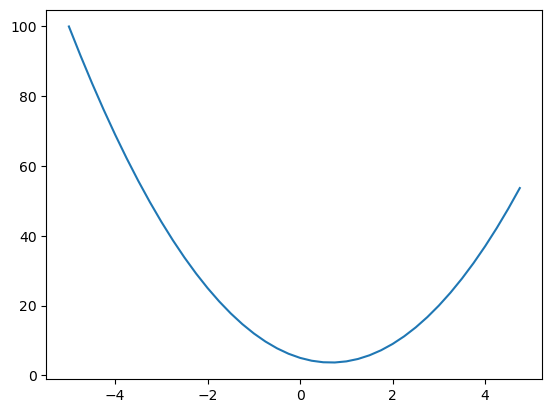

In [2483]:
plt.plot(xs,ys)
plt.show()

In [2484]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.grad=0.0
        self._backward=lambda:None
        self.label=label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out= Value(self.data+other.data,(self,other),('+'))
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad

        out._backward=_backward
        return out

    def __sub__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data-other.data,(self,other),('-'))
        def _backward():
            self.grad+=1*out.grad
            other.grad=(-1)*out.grad
        out._backward=_backward
        return out
        
    def __mul__(self,other):
         other=other if isinstance(other, Value) else Value(other)
         out= Value(self.data*other.data,(self,other),('*'))
         def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad

         out._backward=_backward
         return out

    def __rmul__(self,other):
        return self*other

    def __radd__(self,other):
        return other+self

    def tanh(self):
        x=self.data
        t=((math.exp(2*x)-1)/(math.exp(2*x)+1))
        out=Value(t,(self,),'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out

    def exp(self):
        x=self.data
        t=math.exp(x)
        out=Value(t,(self,),'exp')
        def _backward():
            self.grad+=(t)*out.grad
        out._backward=_backward
        return out

    # def __truediv__(self,other):
    #     other=other if isinstance(other,Value) else Value(other)
    #     out=Value((self.data/other.data),(self,other),'/')
    #     def _backword():
    #         self.grad+=(1/other.data)*out.grad
    #         other.grad+=(-self.data/(other.data)**2)*out.grad
    #     out._backward=_backword()
    #     return out

    def __pow__(self,other):
        assert isinstance (other,(int,float))
        out=Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad+=(other*(self.data)**(other-1))*out.grad
        out._backward=_backward
        return out
        
            
    def __truediv__(self,other):
        return self*(other**-1)

    def backward(self):
        topo = []
        visited = set()
    
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
    
        build_topo(self)

        # Start the backward pass with grad=1.0 for the root node (self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()  # Corrected from _backward() to _backword()
            


In [2485]:
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b
e.label='e'
d=e+c
d.label='d'
f=Value(-2.0,label='f')
L=d*f
L.label='L'


In [2486]:
pip install graphviz


Note: you may need to restart the kernel to use updated packages.


In [2487]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s |  data %.4f |grad %.4f}" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


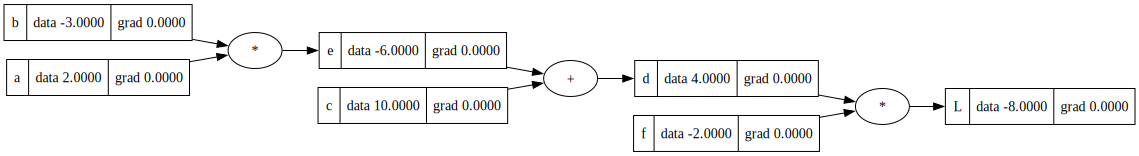

In [2488]:
draw_dot(L)

In [2489]:
f=Value(-2.0,label='f')
L=d*f
L.label='L'

In [2490]:
L.grad=1
d.grad=-2
f.grad=4
c.grad=-2
e.grad=-2
a.grad=6
b.grad=-4

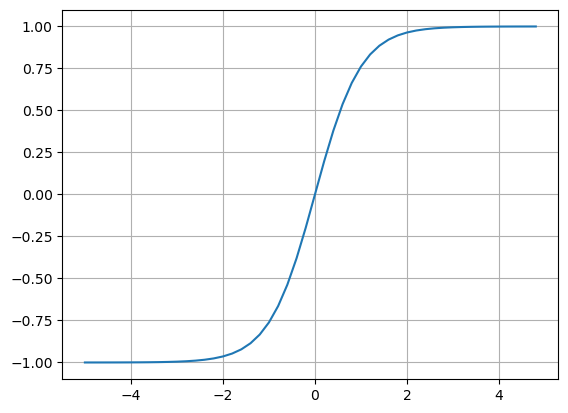

In [2491]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid()

plt.show()

In [2492]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh()
o.label='o'


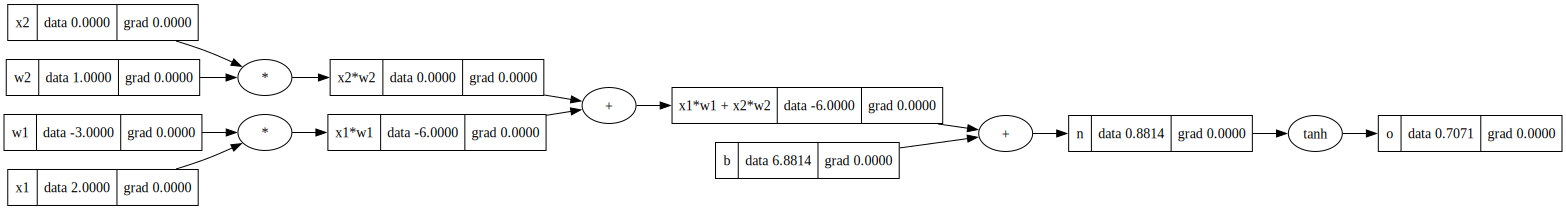

In [2493]:
draw_dot(o)

In [2494]:
# o.grad=1
# n.grad=1-(o.data)**2
# b.grad=n.grad
# x1w1x2w2.grad=n.grad
# x1w1.grad=x1w1x2w2.grad
# x2w2.grad=x1w1x2w2.grad
# x1.grad=w1.data*x1w1.grad
# w1.grad=x1.data*x1w1.grad #important
# x2.grad=w2.data*x2w2.grad
# w2.grad=x2.data*x2w2.grad  #important

In [2495]:
# o.grad=1.0
# o._backword()
# n._backword()
# x1w1x2w2._backword()
# x1w1._backword()
# x2w2._backword()

In [2496]:
# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)
# topo

In [2497]:
# # to get rid of calling backpropogation at every step manually we are taking support of topological sort but in revresed order
# for node in reversed(topo):
#     node._backword()

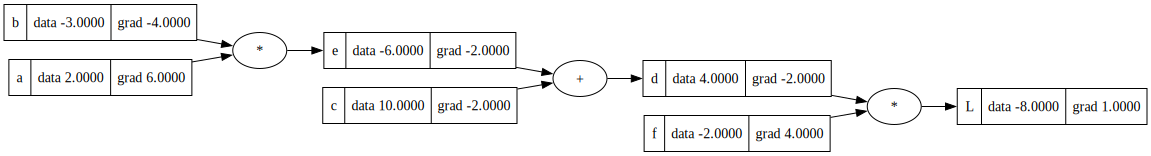

In [2498]:
draw_dot(L)

In [2499]:
# o.grad=1
o.backward()

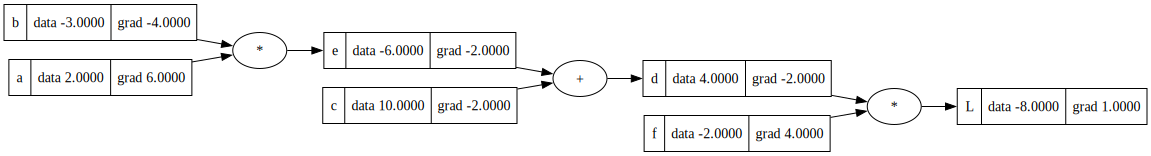

In [2500]:
draw_dot(L)

In [2501]:
g=a*12

In [2502]:
print(g)

Value(data=24.0)


In [2503]:
m=2*a

In [2504]:
m

Value(data=4.0)

In [2505]:
p=d/f

In [2506]:
p

Value(data=-2.0)

In [2507]:
# q=c-a
# q

In [2508]:
# t=a+b

In [2509]:
# t

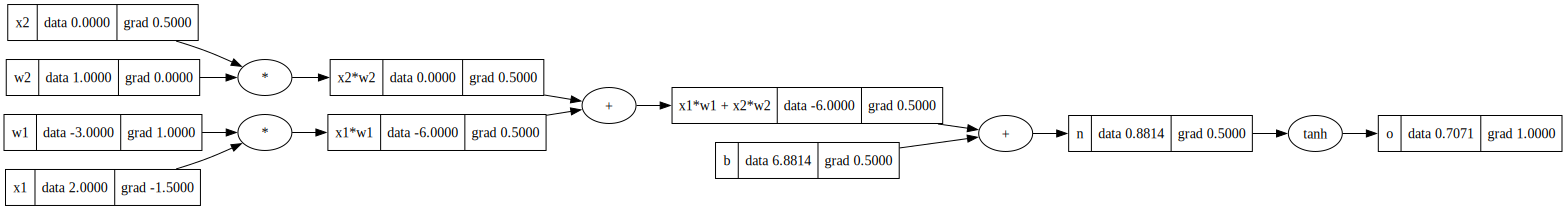

In [2510]:
draw_dot(o)

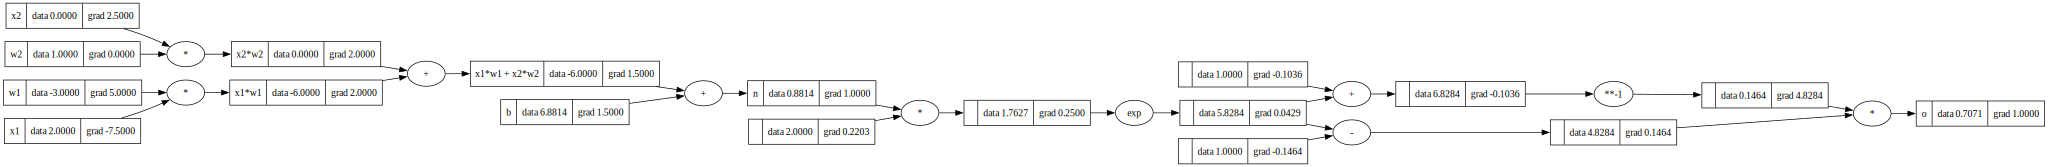

In [2511]:
e=(2*n).exp()
o=(e-1)/(e+1)
# ------------
o.label='o'
o.backward()
draw_dot(o)

In [2512]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2513]:
import torch

x1=torch.Tensor([2.0]).double()   ;x1.requires_grad=True
w1=torch.Tensor([-3.0]).double()  ;w1.requires_grad=True
x2=torch.Tensor([0.0]).double()   ;x2.requires_grad=True
w2=torch.Tensor([1.0]).double()   ;w2.requires_grad=True
b=torch.Tensor([6.8813735870195432]);b.requires_grad=True
n=x1*w1+x2*w2+b
o=torch.tanh(n)

print(o.data.item())
o.backward()

print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [2514]:
class Neuron:
    def __init__(self,nin):  #nin- no. of input features to the neuron
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x):
        act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out= act.tanh()
        return out
        
    def parameters(self):
        params=self.w+[self.b]
        return params

class Layer:
    def __init__(self,nin,nout): #nout-no. of neurons in the layer   #nin- no. of input features to each neuron
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        params=[]
        for neuron in self.neurons:
            ps=neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self,nin,nouts): # nouts-array of no. of neurons in each layer   # nin- no. of input features to each neuron
        sz=[nin]+nouts
        self.Layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.Layers:
            x=layer(x)
        return x

    def parameters(self):
        params=[]
        for layer in self.Layers:
            ps=layer.parameters()
            params.extend(ps)
        return params

In [2515]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.8001258001259836)

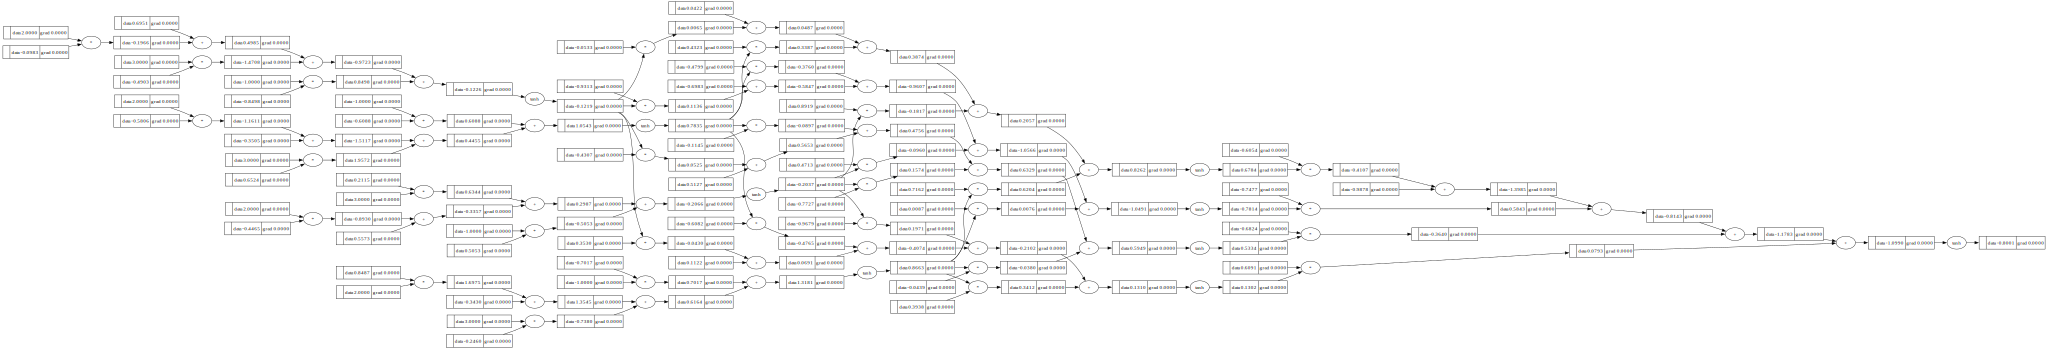

In [2516]:
draw_dot(n(x))

In [2517]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [2518]:
ypred=[n(x) for x in xs]

In [2519]:
ypred

[Value(data=-0.8001258001259836),
 Value(data=-0.18396822418834669),
 Value(data=-0.9583536998172449),
 Value(data=-0.38844982291016666)]

In [2520]:
loss=sum(((yout-ygt)**2 for ygt,yout in zip(ys,ypred)),Value(0))

In [2521]:
loss

Value(data=5.835888080471719)

In [2522]:
loss.backward()

In [2523]:
n.Layers[0].neurons[0].w[0].grad

-0.35833484099593793

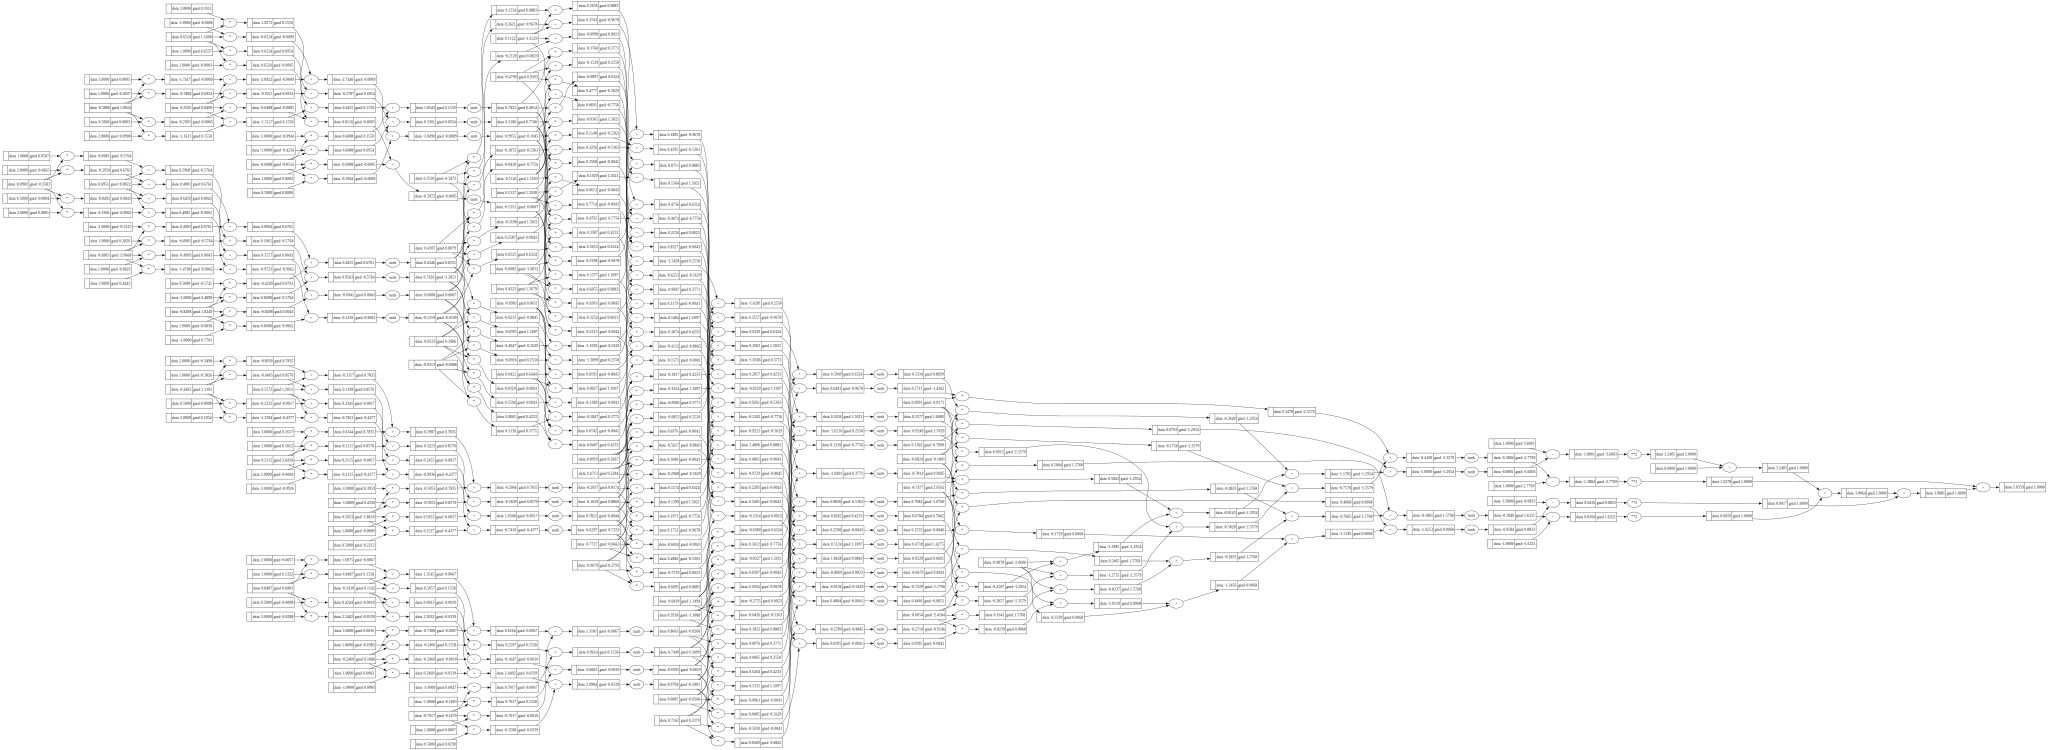

In [2524]:
draw_dot(loss)

In [2525]:
len(n.parameters())

41

In [2526]:
n(x)

Value(data=-0.8001258001259836)

In [2527]:
prevloss=loss
prevloss

Value(data=5.835888080471719)

In [2528]:
# for p in n.parameters():  
#     p.data+=(-0.01)*p.grad

In [2529]:
# forward  pass
for k in range(20):
    ypred=[n(x) for x in xs]
    loss=sum(((yout-ygt)**2 for ygt,yout in zip(ys,ypred)),Value(0))

    # backward pass
    for p in n.parameters():
        p.grad=0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data+=(-0.01)*p.grad

    print(k,loss.data)

0 5.835888080471719
1 5.0333679110599725
2 4.046702898861297
3 3.140555017101982
4 2.477715438137643
5 1.9748893702419936
6 1.5422431887465278
7 1.1804251941695076
8 0.9129138766870595
9 0.7260039389088659
10 0.5938428449859151
11 0.49759034015536596
12 0.4253609607144403
13 0.3696794509661689
14 0.3257341297036691
15 0.290339627057027
16 0.26132753591877933
17 0.23718265421880536
18 0.216820634186352
19 0.19944854414066274


In [2530]:
ypred

[Value(data=0.7143222418558303),
 Value(data=-0.7857100395897333),
 Value(data=-0.9638741022766171),
 Value(data=0.7342717647229975)]

In [2531]:
# backward pass
# loss.backward() 

In [2532]:
# prevloss-loss

In [2533]:
# ypred

In [2534]:
# ys

In [2535]:
# n.parameters()

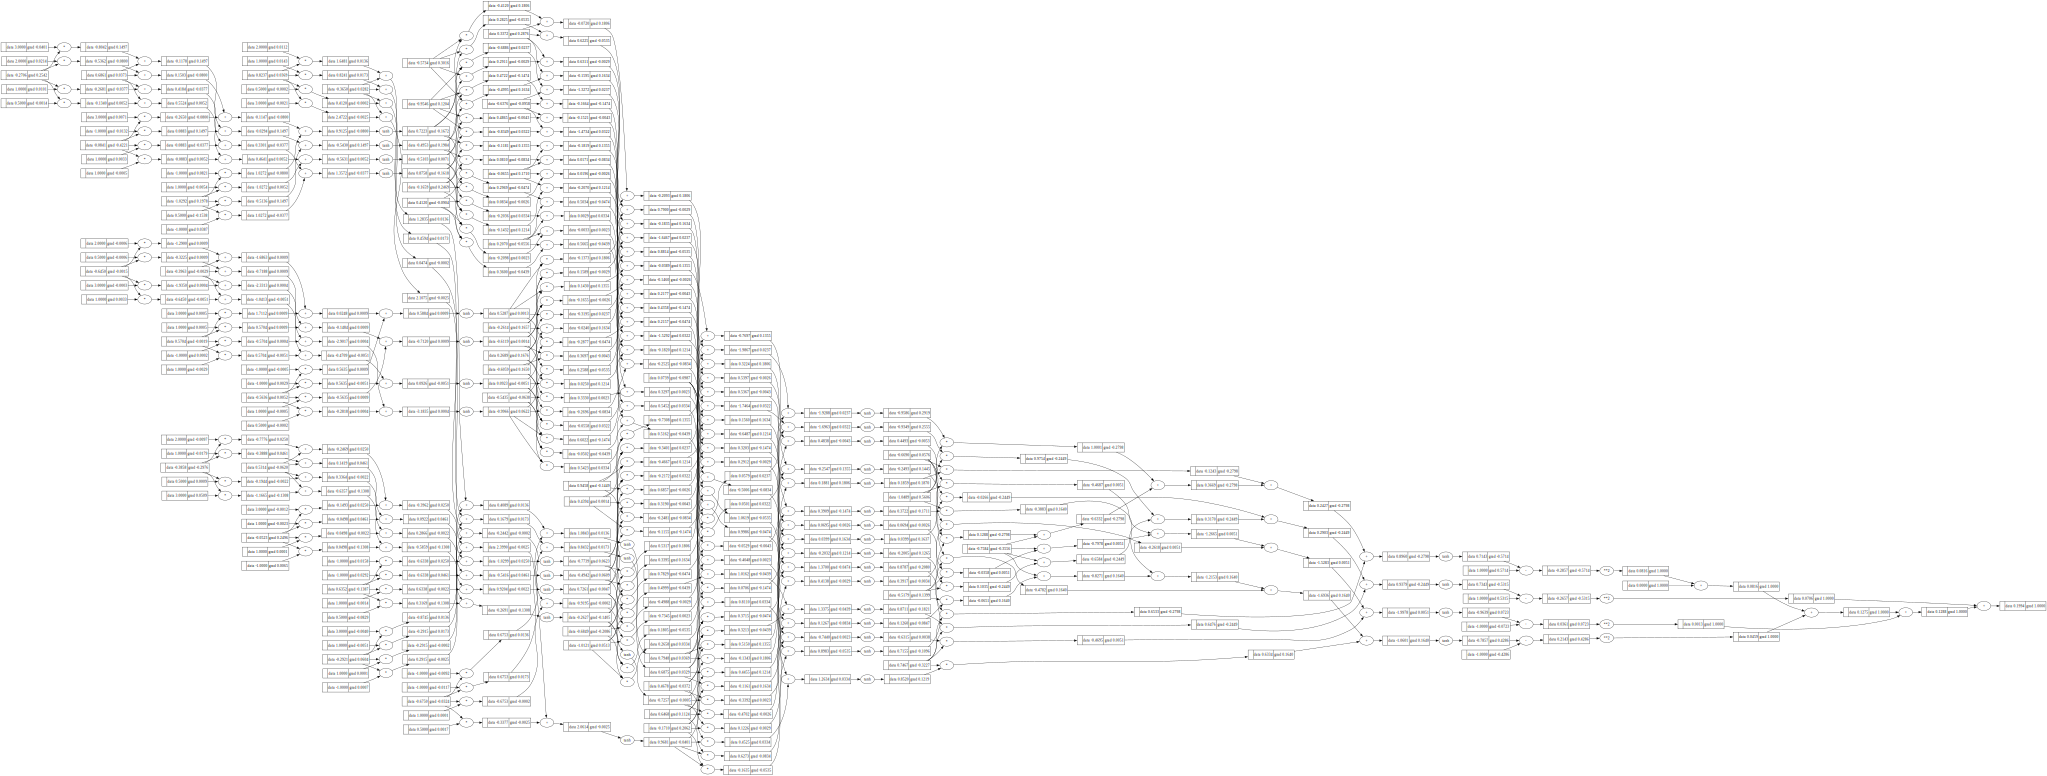

In [2536]:
draw_dot(loss)

In [2537]:
len(n.parameters())

41